<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_with_uid_embedding_swa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [ ]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

In [ ]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


loading drive

In [ ]:
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


Loading dataframes

In [ ]:
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train_id.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test_id.csv',index_col=[0])
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,C9_std_isna,C10_std_isna,C11_std_isna,C12_std_isna,C13_std_isna,C14_std_isna,D1_mean_isna,D1_std_isna,D2_mean_isna,D2_std_isna,D3_mean_isna,D3_std_isna,D4_mean_isna,D4_std_isna,D5_mean_isna,D5_std_isna,D6_mean_isna,D6_std_isna,D7_mean_isna,D7_std_isna,D8_mean_isna,D8_std_isna,D9_mean_isna,D9_std_isna,D10_mean_isna,D10_std_isna,D11_mean_isna,D11_std_isna,D12_mean_isna,D12_std_isna,D13_mean_isna,D13_std_isna,D14_mean_isna,D14_std_isna,D15_mean_isna,D15_std_isna,V1_mean_isna,V1_std_isna,isFraud,id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,Wnan315.013926-13.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,Wgmail.com325.027551.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,Woutlook.com330.046631.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,Wyahoo.com476.018132-111.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Hgmail.com420.044971.0


Reduce memory useage

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2793.39 MB
Memory usage after optimization is: 678.37 MB
Decreased by 75.7%
Memory usage of dataframe is 2392.90 MB
Memory usage after optimization is: 580.09 MB
Decreased by 75.8%


In [ ]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [ ]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data,epochs):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0
        self.epochs=epochs
        self.val=0
        self.wts=[]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        if roc_val>self.val:
          self.val=roc_val
          self.epoch=10
          self.wts=self.model.get_weights()
        else:
          self.epoch-=1
        if self.epoch==0:
          self.model.set_weights(self.wts)
          self.model.stop_training = True
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model(dim):
  K.clear_session()


  uid=Input((1,))
  inp=Input((873,))
  emb=Embedding(input_dim=dim,output_dim=4)(uid)
  emb=Flatten()(emb)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  emb=Flatten()(emb)
  x=Concatenate()([emb,x])
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp,uid],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

Adding all datasets

In [ ]:
trn_s=trn.shape[0]
df=pd.concat([trn,tst],0).reset_index(drop=True)
del([trn,tst])
gc.collect()


autoenc=pd.read_csv('/content/gdrive/My Drive/fraud/without_id.csv',index_col=[0])
autoenc=reduce_mem_usage(autoenc)

autoenc.columns=[i for i in range(444,444+autoenc.shape[1])]


df=pd.concat([df,autoenc],1)
del([autoenc])
gc.collect()

trn=df.loc[:trn_s-1]
tst=df.loc[trn_s:].reset_index(drop=True)
del([df])
gc.collect()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Memory usage of dataframe is 2151.40 MB
Memory usage after optimization is: 544.13 MB
Decreased by 74.7%


0

In [ ]:
categorical=[str(i) for i in range(444)]
trn[categorical]=trn[categorical].astype('uint8')
tst[categorical]=tst[categorical].astype('uint8')

In [ ]:
class stocasticensembling(Callback):
  def __init__(self,model_name,alpha1,alpha2,iter_per_epoch,cycle_len,seqs_dict,start_inx=0,save_se_weights=False,folder='/content',**kwargs):
    #save_se_weights: save after each epoch ?

    super(stocasticensembling,self).__init__()
    self.model_count=0
    self.alpha1=alpha1
    self.alpha2=alpha2
    self.clr_iterations=0
    self.cycle_num=cycle_len
    self.cycle_len=cycle_len
    self.iter_per_epoch=iter_per_epoch
    self.iter_per_cycle = self.cycle_len * self.iter_per_epoch
    self.save_se_weights=save_se_weights
    self.start_inx=start_inx
    self.swa_weights=[]
    self.folder=folder
    self.seqs_dict=seqs_dict
    self.model_name=model_name
    self.prob_dict={k: [] for k in self.seqs_dict.keys()}
    self.lrs=[]

  def on_train_end(self,logs={}):
    self.weight_update()
    self.model.set_weights(self.swa_weights)
    self.snapsort()
    for seq_names,probs in self.prob_dict.items():
      self.prob_dict[seq_names]=np.concatenate(probs,axis=-1)
  
  
  def on_epoch_begin(self,epoch,logs=None):
    self.current_epoch=epoch
  
  
  def on_epoch_end(self,epoch,logs=None):
    self.cycle_num+=1
    if (self._t_cycle() !=1) or (epoch == 15):
      return
    self.snapsort()
    self.weight_update()
    self.model_count+=1
  
  
  def on_batch_begin(self,batch,logs=None):
    self.clr_iterations+=1
    lr=self._clr_schedule()
    self.lrs.append(lr)
    K.set_value(self.model.optimizer.lr,lr)
  
  
  def snapsort(self):
    print(self.clr_iterations)
    print(K.eval(self.model.optimizer.lr))
    for seq_name,seq in self.seqs_dict.items():
      self.prob_dict[seq_name].append(self.model.predict(seq,steps=len(seq)))
  
  
  def weight_update(self):
    weights=self.model.get_weights()
    if self.model_count==0:
      self.swa_weights=weights
    for i in range(0,len(weights)):
      self.swa_weights[i]=(self.swa_weights[i]*self.model_count+weights[i])/(self.model_count+1)
  
  
  def _t_cycle(self):
        return (((self.clr_iterations - 1) % self.iter_per_cycle) + 1) / self.iter_per_cycle
  
  
  def _clr_schedule(self):
    return ((1.0 - 1.0 *self._t_cycle()) * self.alpha2) + (1.0 *self._t_cycle() *self.alpha1)

In [ ]:
from sklearn.model_selection import KFold
splits=KFold(n_splits=5)
gc.collect()
pre=np.zeros((506691,1))
# tst=tst.drop(['isFraud'],1)
for train_index,test_index in tqdm(splits.split(trn)):
  X_train, X_test = trn.loc[train_index], trn.loc[test_index]
  y_train, y_test = X_train['isFraud'], X_test['isFraud']
  ids={}
  for en,id in enumerate(X_train['id'].unique()):
    ids[id]=en+2
  X_train['id']=X_train['id'].map(lambda x: ids.get(x,1))
  X_test['id']=X_test['id'].map(lambda x: ids.get(x,1))
  dim=X_train['id'].nunique()+2
  gc.collect()
  trn_id,tst_id=X_train['id'],X_test['id']
  X_train=X_train.drop(['isFraud','id'],1)
  X_test=X_test.drop(['isFraud','id'],1)
  seqs_dict={'test':[tst.drop(['id'],1),tst['id'].map(lambda x: ids.get(x,1))]}
  se = stocasticensembling(seqs_dict=seqs_dict, cycle_len=4, iter_per_epoch=231,
                                  alpha1=5e-4, alpha2=5e-3,
                                   model_name="model", verbose=1)
  mod=load_model(dim)
  roc = RocCallback(validation_data=([X_test,tst_id], y_test),epochs=10)
  mod.compile(optimizer=Nadam(),loss='binary_crossentropy')
  es=EarlyStopping(monitor='acu_val',min_delta=0.0001,mode='min',restore_best_weights=True,patience=10)
  mod.fit([X_train,trn_id],y_train,validation_data=([X_test,tst_id],y_test),batch_size=2048,epochs=16,callbacks=[se])
  
  del[(X_train,y_train)]
  gc.collect()

  mod.fit([X_test,tst_id],y_test,epochs=2,batch_size=2048)
  pre+=se.prob_dict['test'].mean(1).reshape(506691,1)
  pre+=mod.predict([tst.drop(['id'],1),tst['id'].map(lambda x: ids.get(x,1))])

  
  del([X_test,y_test,mod])
  gc.collect()


0it [00:00, ?it/s]

Epoch 1/16
231/231 [==============================] - 6s 19ms/step - loss: 0.1406 - val_loss: 0.0779
Epoch 2/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0642 - val_loss: 0.0707
Epoch 3/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0412 - val_loss: 0.0739
Epoch 4/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0306 - val_loss: 0.0759
924
0.0005
Epoch 5/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0275 - val_loss: 0.0791
Epoch 6/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0167 - val_loss: 0.0912
Epoch 7/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0124 - val_loss: 0.0884
Epoch 8/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0100 - val_loss: 0.0843
1848
0.0005
Epoch 9/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0104 - val_loss: 0.0935
Epoch 10/16
231/231 [==============================] - 4s 15ms/step 


1it [01:51, 111.93s/it]

Epoch 1/16
231/231 [==============================] - 6s 19ms/step - loss: 0.1306 - val_loss: 0.0977
Epoch 2/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0617 - val_loss: 0.0805
Epoch 3/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0393 - val_loss: 0.0767
Epoch 4/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0291 - val_loss: 0.0772
924
0.0005
Epoch 5/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0262 - val_loss: 0.0825
Epoch 6/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0168 - val_loss: 0.0757
Epoch 7/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0119 - val_loss: 0.0810
Epoch 8/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0096 - val_loss: 0.0788
1848
0.0005
Epoch 9/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0100 - val_loss: 0.0843
Epoch 10/16
231/231 [==============================] - 3s 15ms/step 


2it [03:44, 112.12s/it]

Epoch 1/16
231/231 [==============================] - 6s 19ms/step - loss: 0.1493 - val_loss: 0.0919
Epoch 2/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0647 - val_loss: 0.0781
Epoch 3/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0408 - val_loss: 0.0751
Epoch 4/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0305 - val_loss: 0.0746
924
0.0005
Epoch 5/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0272 - val_loss: 0.0866
Epoch 6/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0172 - val_loss: 0.0847
Epoch 7/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0123 - val_loss: 0.0808
Epoch 8/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0102 - val_loss: 0.0792
1848
0.0005
Epoch 9/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0104 - val_loss: 0.0823
Epoch 10/16
231/231 [==============================] - 4s 15ms/step 


3it [05:37, 112.24s/it]

Epoch 1/16
231/231 [==============================] - 6s 20ms/step - loss: 0.1256 - val_loss: 0.0900
Epoch 2/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0631 - val_loss: 0.0758
Epoch 3/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0403 - val_loss: 0.0703
Epoch 4/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0301 - val_loss: 0.0693
924
0.0005
Epoch 5/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0270 - val_loss: 0.0719
Epoch 6/16
231/231 [==============================] - 4s 16ms/step - loss: 0.0166 - val_loss: 0.0681
Epoch 7/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0120 - val_loss: 0.0680
Epoch 8/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0100 - val_loss: 0.0672
1848
0.0005
Epoch 9/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0105 - val_loss: 0.0695
Epoch 10/16
231/231 [==============================] - 4s 15ms/step 


4it [07:30, 112.47s/it]

Epoch 1/16
231/231 [==============================] - 6s 19ms/step - loss: 0.1315 - val_loss: 0.0946
Epoch 2/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0620 - val_loss: 0.0872
Epoch 3/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0407 - val_loss: 0.0888
Epoch 4/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0299 - val_loss: 0.0860
924
0.0005
Epoch 5/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0270 - val_loss: 0.0936
Epoch 6/16
231/231 [==============================] - 4s 16ms/step - loss: 0.0168 - val_loss: 0.0880
Epoch 7/16
231/231 [==============================] - 4s 15ms/step - loss: 0.0127 - val_loss: 0.0918
Epoch 8/16
231/231 [==============================] - 3s 15ms/step - loss: 0.0100 - val_loss: 0.0930
1848
0.0005
Epoch 9/16
231/231 [==============================] - 4s 16ms/step - loss: 0.0106 - val_loss: 0.0949
Epoch 10/16
231/231 [==============================] - 4s 16ms/step 


5it [09:23, 112.67s/it]


In [ ]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre.ravel()/10
sub=sub.set_index('TransactionID')
sub.head()

,isFraud
TransactionID,
3663549,0.000029
3663550,0.000023
3663551,0.015248
3663552,0.001586
3663553,0.001490


In [ ]:
sub.to_csv('sub.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


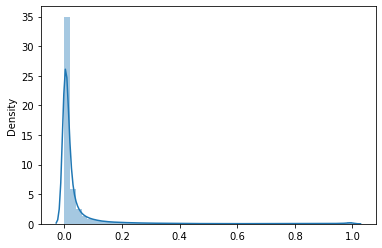

In [ ]:
import seaborn as sns
sns.distplot(pre/10)